In [54]:
# -*- coding: utf-8 -*-

from __future__ import division, print_function, absolute_import, unicode_literals
import sys
import numpy as np  # For array operations
import sidpy as sid
from sidpy.sid import Reader
import h5py
import os
os.listdir('.')
import re
from pathlib import Path
import pyNSID
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pyUSID as usid

if sys.version_info.major == 3:
    unicode = str


reader_name = 'ARHDF5 FFM'
description = 'Asylum Research HDF5 file typically used for storing spatial maps of force-distance curves'


class ARhdf5ReaderFFM(Reader):

	def read(self, verbose=False):
		file_path = self._input_file_path
		self.notes = None
		self.scan_size = { 'X':0, 'Y':0}
		self.scan_points = None
		self.channels_name = []
		self.verbose = verbose

		try:
			h5_f = h5py.File('/Users/14f/Desktop/pmma_20003.h5', 'r')
		except:
			print('Unable to open the file', data_filepath)
			raise


		self.notes = h5_f.attrs['Note'].decode('utf-8')
		self.scan_size['X'] = h5_f['FFM']['Raw']['ScanSize'].shape[0]
		self.scan_size['Y'] = h5_f['FFM']['Raw']['ScanSize'].shape[1]
		self.scan_points = h5_f['FFM']['Raw']['FastMapScanPoints']
		channels_name = list(h5_f['FFM']['Raw'].attrs['Channels'])
		self.channels_name = [name.decode('utf-8') for name in channels_name]
		try:
			self.scan_points = np.float(self.note_value('FastMapOptScanPoints'))
		except NameError:
			self.scan_points = np.float(self.note_value('ScanPoints'))


		if self.verbose:
			print('Scan Size [X, Y]:', self.scan_size)
			print('Scan Points:', self.scan_points)
			print('Channels names:', self.channels_name)


		x_dim = np.linspace(0, np.float(self.note_value('ScanSize')), self.scan_size['X'])

		y_dim = np.linspace(0, np.float(self.note_value('ScanSize')), self.scan_size['Y'])

		z_dim = np.float(self.scan_points)


		datasets = []


		general_metadata = { 'Translator': 'ARhdf5 FFM',
						'Instrument': 'Asylum Research' + self.note_value('MicroscopeModel'),
						'AR software version': self.note_value('Version'),}

		dict_metadata = dict({'general': general_metadata})


		for index, channel in enumerate(self.channels_name):
			main_dset = np.empty((self.scan_size['X'], self.scan_size['Y'], self.scan_points))
			for column in np.arrange(self.scan_size['X']):
				for row in np.arrange(self.scan_size['Y']):
					AR_pos_string = str(column) + ':' + str(row)
					points_start = self.scan_points[column, row]
					main_dset[column, row, :] = h5_f['FFM']['Defl']['AR_pos_string'][index, points_start]

			quant_unit = self.get_def_unit(channel)

			data_set = sid.Dataset.from_array(main_dset, name='Delf')
			data_set.data_type = sid.DataType.SPECTRAL_IMAGE


			data_set.units = quant_unit
			data_set.quantity = channel

			data_set.set_dimension(0, sid.Dimension(x_dim,
										       name='x',
										       units='m', quantity='z',
										       dimension_type='spatial'))
			data_set.set_dimension(1, sid.Dimension(y_dim,
											   name='y',
											   units='m', quantity='y',
											   dimension_type='spatial'))
			data_set.set_dimension(2, sid.Dimension(z_dim,
											   name='Time',
											   units='s', quantity='z',
											   dimension_type='spectral'))


		
			chan_metadata = dict(h5_f['FFM']['Delf'].attrs)
			new_dict = {**chan_metadata}
			data_set.metadata = new_dict

			datasets.append(data_set)


		for index, image in enumerate(h5_f['Image'].keys()):
			main_dset = np.array(h5_f['Image'])

			quant_unit = self.get_def_unit(image)

			data_set = sid.Dataset.from_array(main_dset, name='Image')
			data_set.data_type = sid.DataType.IMAGE


			data_set.units = quant_unit
			data_set.quantity = channel

			data_set.set_dimesion(0, sid.Dimension(x_dim,
											   name='x',
											   units=quant_unit, quantity='x',
											   dimension_type='spatial'))
			data_set.set_dimension(1, sid.Dimension(y_dim, name='y',
												units=quant_unit, quantity='y',
												dimension_type='spatial'))

			chan_metadata = dict(h5_f['Image'].attrs)
			new_dict = {**chan_metadata}
			data_set.metadata = new_dict

			datasets.append(data_set)

		return datasets


	def can_read(self):

		file_path = self._input_file_path
		extension = os.path.splitext(file_path)[1][1:]
		if extension not in ['hdf5', 'h5']:
			return False

		try:
			h5_f = h5py.File(file_path, 'r')
		except:
			return False
		if 'FFM' not in h5_f.keys():
			return False
		if not isinstance(h5_f['FFM'], h5py.Group):
			return False
		return

	def note_value(self, name):
		try:
			match = re.search(r"^" + name + ":+(.+$)", self.notes, re.M)
			if not match:
				raise Exception

		except:
			match = re.search(r"^" + name + ":+(.+$)", self.notes, re.M)
		if (match):
			matched = match.groups()
			if len(matched) == 1:
				return match.groups()[0]
			else:
				print('WARNING! Multiple value matched! \n Only the first is returned')
				return match.groups()[0]
		else:
			raise NameError('Note entry with name "{}" not found'.format(name))


	def get_def_unit(self, chan_name):

		if not isinstance(chan_name, (str, unicode)):
			raise TypeError('The channel name must be of type string')

		if chan_name.startswith('Phas'):
			default_unit = 'deg'
		elif chan_name.startswith('Curr'):
			default_unit = 'A'
		elif chan_name.startswith('Freq'):
			default_unit = 'Hz'
		elif chan_name.startswith('Bias'):
			default_unit ='V'
		elif(chan_name.startswith('Amp') or
		 	chan_name.startswith('Raw') or
			 chan_name.startswith('ZSensor') or
			 chan_name.startswith('Defl') or
			 chan_name.startswith('MapHeight')):
			default_unit = 'm'
		elif (chan_name.startswith('Seconds') or 
			 chan_name == 'TriggerTime'):
			default_unit = 's'
		elif chan_name.startswith('ATC Heater Case Temp'):
			default_unit = 'Celsius'
		elif chan_name =='MapAdhesion':
			default_unit = 'N/m^2'
		elif chan_name == 'HeaterHumidity':
			default_unit = 'g/m^3'
		elif chan_name.endswith('LVDT'):
			default_unit = 'm'
		else:
			if self.debug:
				print('Uknown unit for channel: {}'.format(chan_name))
				print('Unit set to "unknown"')
			default_unit = 'unknown'

		return default_unit

h5_path = r'/Users/14f/Desktop/ARDFtoHDF5/pmma_20003.h5'
h5_f = h5py.File(h5_path, 'r+')

In [55]:
h5_path = r'/Users/14f/Desktop/ARDFtoHDF5/pmma_20003.h5'
h5_f = h5py.File(h5_path, 'r+')

In [44]:
print('Tree View:')
print('--------------------')
sid.hdf_utils.print_tree(h5_f)
print('\n')
print('Contents of H5 file:')
print('--------------------')
print('Name of Keys/Group Members:')
print(list(h5_f.keys()))   
print('\n')
print('Shapes of Datasets for FFM Group:')
print('---------------------------------')
print(h5_f['FFM']['Defl'][:].shape, h5_f['FFM']['Drive'][:].shape, h5_f['FFM']['Raw'][:].shape)

Tree View:
--------------------
/
├ FFM
  ---
  ├ Defl
  ├ Drive
  ├ Raw
├ Image
  -----
  ├ AdhesionTrace
  ├ ForceTrace
  ├ HeightTrace
  ├ YoungsHertzTrace
  ├ ZSensorTrace


Contents of H5 file:
--------------------
Name of Keys/Group Members:
['FFM', 'Image']


Shapes of Datasets for FFM Group:
---------------------------------
(256, 256, 1670) (256, 256, 1670) (256, 256, 1670)


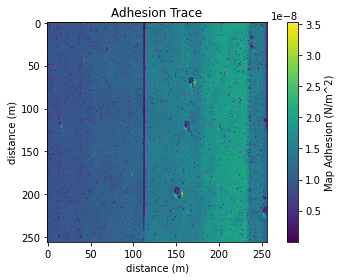

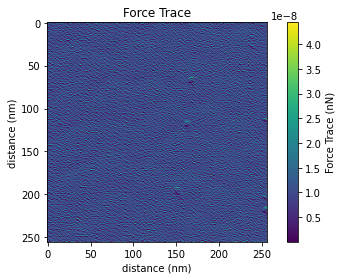

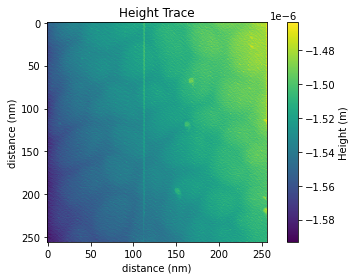

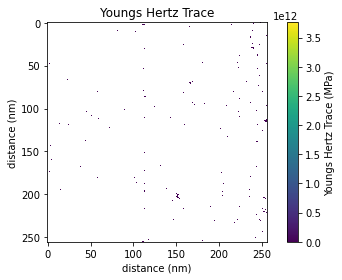

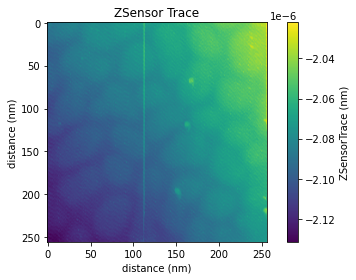

In [61]:
image_set = np.array(h5_f['Image']['AdhesionTrace'][:])
image_set = sid.Dataset.from_array(image_set)
image_set.data_type = 'image'
image_set.units = 'N/m^2'
image_set.quantity = 'Map Adhesion'
image_set.title = 'Adhesion Trace'
image_set.set_dimension(0, sid.Dimension(np.arange(image_set.shape[0]), 'x'))
image_set.x.dimension_type = 'spatial'
image_set.x.units = 'm'
image_set.x.quantity = 'distance'
image_set.set_dimension(1, sid.Dimension(np.arange(image_set.shape[1]), 'y'))
image_set.y.dimension_type = 'spatial'
image_set.y.units = 'm'
image_set.y.quantity = 'distance'
image_set.plot()
##########################################
image_set = np.array(h5_f['Image']['ForceTrace'][:])
image_set = sid.Dataset.from_array(image_set)
image_set.data_type = 'image'
image_set.units = 'nN'
image_set.quantity = 'Force Trace'
image_set.title = 'Force Trace'
image_set.set_dimension(0, sid.Dimension(np.arange(image_set.shape[0]), 'x'))
image_set.x.dimension_type = 'spatial'
image_set.x.units = 'nm'
image_set.x.quantity = 'distance'
image_set.set_dimension(1, sid.Dimension(np.arange(image_set.shape[1]), 'y'))
image_set.y.dimension_type = 'spatial'
image_set.y.units = 'nm'
image_set.y.quantity = 'distance'
image_set.plot()
##########################################
image_set = np.array(h5_f['Image']['HeightTrace'][:])
image_set = sid.Dataset.from_array(image_set)
image_set.data_type = 'image'
image_set.units = 'm'
image_set.quantity = 'Height'
image_set.title = 'Height Trace'
image_set.set_dimension(0, sid.Dimension(np.arange(image_set.shape[0]), 'x'))
image_set.x.dimension_type = 'spatial'
image_set.x.units = 'nm'
image_set.x.quantity = 'distance'
image_set.set_dimension(1, sid.Dimension(np.arange(image_set.shape[1]), 'y'))
image_set.y.dimension_type = 'spatial'
image_set.y.units = 'nm'
image_set.y.quantity = 'distance'
image_set.plot()
##########################################
image_set = np.array(h5_f['Image']['YoungsHertzTrace'][:])
image_set = sid.Dataset.from_array(image_set)
image_set.data_type = 'image'
image_set.units = 'MPa'
image_set.quantity = 'Youngs Hertz Trace'
image_set.title = 'Youngs Hertz Trace'
image_set.set_dimension(0, sid.Dimension(np.arange(image_set.shape[0]), 'x'))
image_set.x.dimension_type = 'spatial'
image_set.x.units = 'nm'
image_set.x.quantity = 'distance'
image_set.set_dimension(1, sid.Dimension(np.arange(image_set.shape[1]), 'y'))
image_set.y.dimension_type = 'spatial'
image_set.y.units = 'nm'
image_set.y.quantity = 'distance'
image_set.plot()
##########################################
image_set = np.array(h5_f['Image']['ZSensorTrace'][:])
image_set = sid.Dataset.from_array(image_set)
image_set.data_type = 'image'
image_set.units = 'nm'
image_set.quantity = 'ZSensorTrace'
image_set.title = 'ZSensor Trace'
image_set.set_dimension(0, sid.Dimension(np.arange(image_set.shape[0]), 'x'))
image_set.x.dimension_type = 'spatial'
image_set.x.units = 'nm'
image_set.x.quantity = 'distance'
image_set.set_dimension(1, sid.Dimension(np.arange(image_set.shape[1]), 'y'))
image_set.y.dimension_type = 'spatial'
image_set.y.units = 'nm'
image_set.y.quantity = 'distance'
image_set.plot()

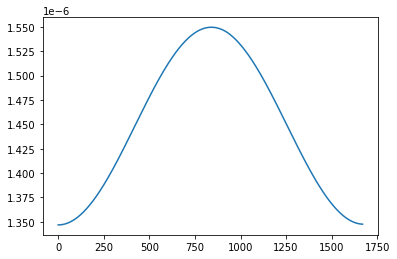

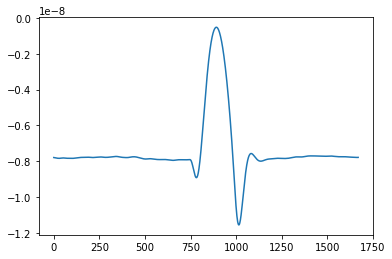

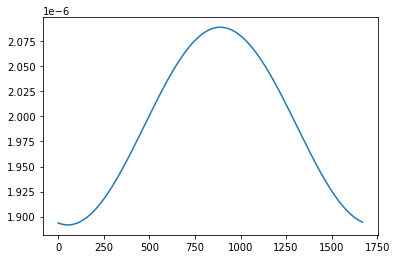

In [53]:
drive_data = h5_f['FFM']['Drive'][:]
plt.figure()
plt.plot(drive_data[10,10, :])

defl_data = h5_f['FFM']['Defl'][:]
plt.figure()
plt.plot(defl_data[10,10,:])


raw_data = h5_f['FFM']['Raw'][:]
plt.figure()
plt.plot(raw_data[10,10,:])